In [67]:
import sys
import os
from pathlib import Path
sys.path.append(
    os.path.dirname(os.path.abspath('.'))
)
from src import QNet, agent_metrics, show_reward, settings
### path load

import japanize_matplotlib
import numpy as np
import torch
from torchvision import datasets
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from data.blur_funcs import FUNCS_GR, ACTIONS_GR, FUNCS_RN, ACTIONS_RN, ACTIONS_WO_RN_BLUR

SEED = 0
device = 'cuda:0'

2 channel weight: =  0.05
RESULT_PATH results/GR/gauss/channel02_weight005_seed00


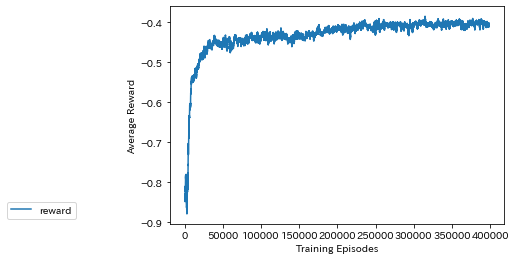

MODEL_PATH results/GR/gauss/channel02_weight005_seed00/Qnet020000.pth
test func gauss
TEST_DATASET_PATH data/GR/test/gauss/c3_dataset.npz


  0%|          | 0/10000 [00:00<?, ?it/s]

init:  0.04551963881928642


  0%|          | 0/10000 [00:00<?, ?it/s]

mse(agent_output, x) 0.01887253772963513
test func random
TEST_DATASET_PATH data/GR/test/random/c3_dataset.npz
init:  0.04602599343577289


  0%|          | 0/10000 [00:00<?, ?it/s]

mse(agent_output, x) 0.021217416378362053
test func smooth
TEST_DATASET_PATH data/GR/test/smooth/c3_dataset.npz
init:  0.04728199786482046


100%|██████████| 10000/10000 [02:33<00:00, 65.13it/s]


mse(agent_output, x) 0.023857433716704873


In [74]:
# 実験条件を指定
ACTIONS_TYPE = 'GR'
TRAIN_TYPE = 'gauss'
ACTIONS = ACTIONS_GR
SEED = 0
#TR_C = 3
TST_C = 3
for setting_num in [4]:
    setting = getattr(settings, f'setting{setting_num}')
    CHANNEL = setting.CHANNEL
    WEIGHT = setting.WEIGHT
    print(CHANNEL, 'channel', 'weight: = ', WEIGHT)
    RESULT_PATH = os.path.join(
        'results/%s/%s/' % (ACTIONS_TYPE, TRAIN_TYPE),
        'channel%02d_weight%03d_seed%02d' % (CHANNEL, int(100*WEIGHT), SEED)
    )
    print("RESULT_PATH", RESULT_PATH)

    # see reward
    ax = plt.subplot(111)
    ma = show_reward(ax, dir_path=RESULT_PATH, mono=False, n=1000, label='reward')
    plt.show()
    
    actions = [lambda x: x] + ACTIONS
    Qnet = QNet(c=CHANNEL, m=[20, 20, len(actions)])
    MODEL_PATH = os.path.join(RESULT_PATH, 'Qnet020000.pth')
    print('MODEL_PATH', MODEL_PATH)
    Qnet.load_state_dict(
        torch.load(MODEL_PATH)
        )
    for TEST_FUNC in ['gauss', 'random', 'smooth']:
        print('test func', TEST_FUNC)
        # load test data
        TEST_DATASET_PATH = 'data/GR/test/%s/c%d_dataset.npz' % (TEST_FUNC, TST_C)
        print("TEST_DATASET_PATH", TEST_DATASET_PATH)
        test_dataset_context = np.load(TEST_DATASET_PATH)
        Dx = test_dataset_context['original_dataset']
        Dy = test_dataset_context['test_dataset']
        Dx = torch.from_numpy(Dx)
        Dy = torch.from_numpy(Dy)

        mse = torch.mean((Dy - Dx)**2).item()
        print('init: ', mse)
        result = agent_metrics(Dy.clone(), Dx, Qnet, actions, channel=CHANNEL)
        mse = result[:, -1].mean()
        print('mse(agent_output, x)', mse)
        np.save(
            os.path.join(RESULT_PATH, f'metrics({TEST_FUNC}).npy'),
            result
        )


2 channel weight: =  0.05
RESULT_PATH results/RN/train_gauss/channel02_weight005_seed00


FileNotFoundError: [Errno 2] No such file or directory: '/home/kato/workspace/selectiveSR/blur_deblur/results/RN/train_gauss/channel02_weight005_seed00/reward.pkl'

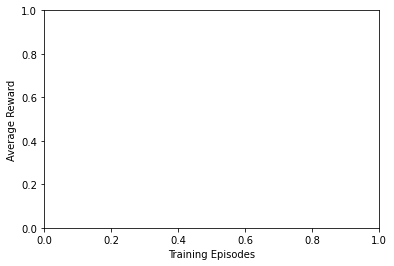

In [9]:
# 学習済みモデルの結果を確認
ACTIONS_TYPE = 'GR'
SEED = 0
#TR_C = 3
TST_C = 3
for setting_num in [4]:
    setting = getattr(settings, f'setting{setting_num}')
    CHANNEL = setting.CHANNEL
    WEIGHT = setting.WEIGHT
    print(CHANNEL, 'channel', 'weight: = ', WEIGHT)
    RESULT_PATH = os.path.join(
        'results/%s/train_gauss/' % (ACTIONS_TYPE,),
        'channel%02d_weight%03d_seed%02d' % (CHANNEL, int(100*WEIGHT), SEED)
    )
    print("RESULT_PATH", RESULT_PATH)

    actions = [lambda x: x] + ACTIONS_RN

    # see reward
    ax = plt.subplot(111)
    ma = show_reward(ax, dir_path=RESULT_PATH, mono=False, n=1000, label='reward')
    plt.show()

    for TEST_FUNC in ['gauss', 'random', 'smooth']:
        print('test func', TEST_FUNC)
        # load test data
        TEST_DATASET_PATH = 'data/GR/test/%s/c%d_dataset.npz' % (TEST_FUNC, TST_C)
        print("TEST_DATASET_PATH", TEST_DATASET_PATH)
        test_dataset_context = np.load(TEST_DATASET_PATH)
        originals = test_dataset_context['original_dataset']
        test_dataset = test_dataset_context['test_dataset']
        test_dataset = torch.from_numpy(test_dataset).to(torch.float32)
        originals = torch.from_numpy(originals).to(torch.float32)

        # load model
        Qnet = QNet(c=CHANNEL, m=[20, 20, len(actions)])
        MODEL_PATH = os.path.join(RESULT_PATH, 'Qnet020000.pth')
        print('MODEL_PATH', MODEL_PATH)
        Qnet.load_state_dict(
            torch.load(MODEL_PATH)
        )
        result = agent_metrics(test_dataset, originals, Qnet, actions, channel=CHANNEL)
        mse = result[:, -1].mean()
        print('MSE(test_dataset, agent_outputs) = ', mse)
        print('action frequency')
        for j in range(5):
            print(j, np.histogram(result[:, j], bins=np.arange(6) - 0.5, density=True))
        print()

        METRIC_PATH = os.path.join(RESULT_PATH, f'metrics{TEST_FUNC}_{int(1000*mse):03d}')
        print("METRIC_PATH", METRIC_PATH)
        np.save(METRIC_PATH, result)
        print('-' * 20)
        print()

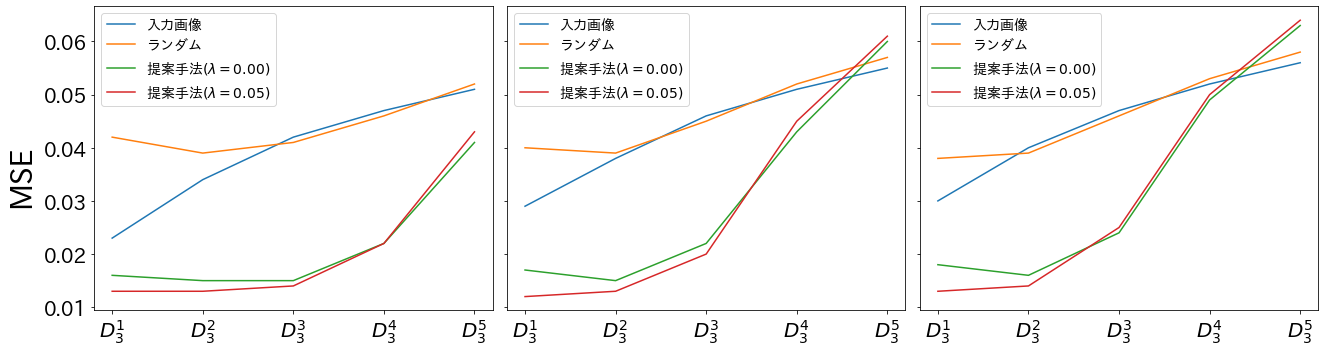

In [65]:
gauss = np.array([
    [0.023, 0.034, 0.042, 0.047, 0.051],
    [0.042, 0.039, 0.041, 0.046, 0.052],
    [0.016, 0.015, 0.015, 0.022, 0.041],
    [0.013, 0.013, 0.014, 0.022, 0.043]
])

random = np.array([
    [0.029, 0.038, 0.046, 0.051, 0.055],
    [0.040, 0.039, 0.045, 0.052, 0.057],
    [0.017, 0.015, 0.022, 0.043, 0.060],
    [0.012, 0.013, 0.020, 0.045, 0.061],
])

smooth = np.array([
    [0.030, 0.040, 0.047, 0.052, 0.056],
    [0.038, 0.039, 0.046, 0.053, 0.058],
    [0.018, 0.016, 0.024, 0.049, 0.063],
    [0.013, 0.014, 0.025, 0.050, 0.064],
])

data = [
    gauss,
    random,
    smooth
]
tick_labels = [
    ['$D_1^1$', '$D_1^2$', '$D_1^3$', '$D_1^4$', '$D_1^5$'],
    ['$D_2^1$', '$D_2^2$', '$D_2^3$', '$D_2^4$', '$D_2^5$'],
    ['$D_3^1$', '$D_3^2$', '$D_3^3$', '$D_3^4$', '$D_3^5$'],
]

labels = ['入力画像', 'ランダム', '提案手法$(\lambda = 0.00)$', '提案手法$(\lambda = 0.05)$']
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18, 5))
for i in range(3):
    axes[i].set_xticks(range(5))
    axes[i].set_xticklabels(tick_labels[i])
    axes[i].tick_params(labelsize=20)
    for j in range(4):
        d = data[i][j]
        axes[i].plot(d, label=labels[j])
    axes[i].legend(loc='upper left', fontsize=14)
fig.text(-0.02, 0.5, 'MSE', va='center', rotation='vertical', fontsize=30)
plt.tight_layout()

2 channel weight: =  0.05
RESULT_PATH results/RN/train_gauss/channel02_weight005_seed00


FileNotFoundError: [Errno 2] No such file or directory: '/home/kato/workspace/selectiveSR/blur_deblur/results/RN/train_gauss/channel02_weight005_seed00/reward.pkl'

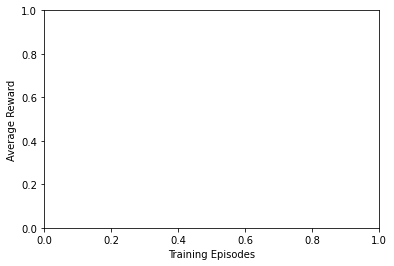

In [9]:
# 学習済みモデルに対しテスト用画像を10個作成してMSEを測定しなおす。
# テスト用のデータセットは, gauss/c3, random/c3, gauss/c5
ACTIONS_TYPE = 'RN'
SEED = 0
#TR_C = 3
TST_C = 3
for setting_num in [3, 4]:
    setting = getattr(settings, f'setting{setting_num}')
    CHANNEL = setting.CHANNEL
    WEIGHT = setting.WEIGHT
    print(CHANNEL, 'channel', 'weight: = ', WEIGHT)
    RESULT_PATH = os.path.join(
        'results/%s/train_gauss/' % (ACTIONS_TYPE,),
        'channel%02d_weight%03d_seed%02d' % (CHANNEL, int(100*WEIGHT), SEED)
    )
    print("RESULT_PATH", RESULT_PATH)

    actions = [lambda x: x] + ACTIONS_RN

    # see reward
    ax = plt.subplot(111)
    ma = show_reward(ax, dir_path=RESULT_PATH, mono=False, n=1000, label='reward')
    plt.show()

    for TEST_FUNC in ['gauss', 'random', 'smooth']:
        print('test func', TEST_FUNC)
        # load test data
        TEST_DATASET_PATH = 'data/GR/test/%s/c%d_dataset.npz' % (TEST_FUNC, TST_C)
        print("TEST_DATASET_PATH", TEST_DATASET_PATH)
        test_dataset_context = np.load(TEST_DATASET_PATH)
        originals = test_dataset_context['original_dataset']
        test_dataset = test_dataset_context['test_dataset']
        test_dataset = torch.from_numpy(test_dataset).to(torch.float32)
        originals = torch.from_numpy(originals).to(torch.float32)

        # load model
        Qnet = QNet(c=CHANNEL, m=[20, 20, len(actions)])
        MODEL_PATH = os.path.join(RESULT_PATH, 'Qnet020000.pth')
        print('MODEL_PATH', MODEL_PATH)
        Qnet.load_state_dict(
            torch.load(MODEL_PATH)
        )
        result = agent_metrics(test_dataset, originals, Qnet, actions, channel=CHANNEL)
        mse = result[:, -1].mean()
        print('MSE(test_dataset, agent_outputs) = ', mse)
        print('action frequency')
        for j in range(5):
            print(j, np.histogram(result[:, j], bins=np.arange(6) - 0.5, density=True))
        print()

        METRIC_PATH = os.path.join(RESULT_PATH, f'metrics{TEST_FUNC}_{int(1000*mse):03d}')
        print("METRIC_PATH", METRIC_PATH)
        np.save(METRIC_PATH, result)
        print('-' * 20)
        print()

2 channel weight: =  0.05
RESULT_PATH results/udlr8_invert_prod_reward3/channel02_weight005_seed00


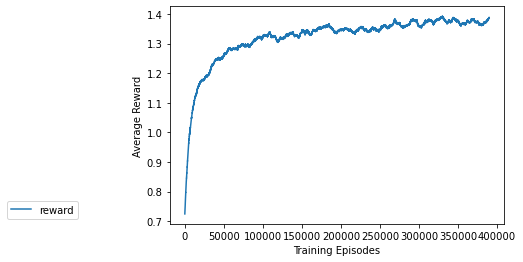

TEST_DATASET_PATH data/udlr8_diag/test_dataset.npz
{0, 1, 2, 3, 4, 5, 6, 7}


  0%|          | 0/10000 [00:00<?, ?it/s]

0.19132275394080483
MODEL_PATH results/udlr8_invert_prod_reward3/channel02_weight005_seed00/Qnet020000.pth


100%|██████████| 10000/10000 [01:53<00:00, 88.23it/s]


MSE(test_dataset, agent_outputs) =  0.042769728048780195


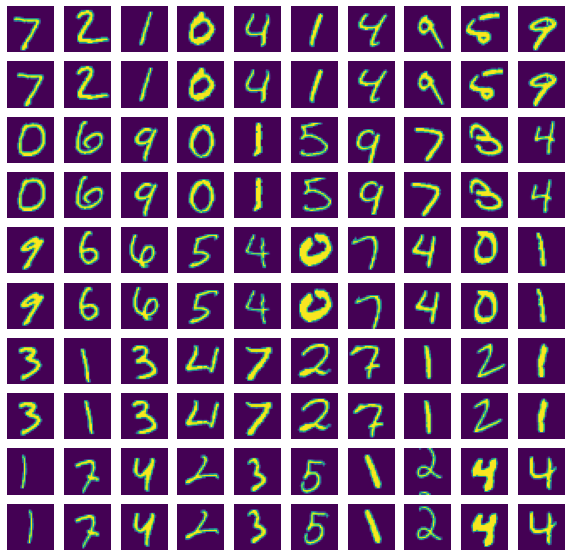

In [ ]:
# INVERT
SEED = 0
data_dir = 'udlr8_diag'
outdir = f'udlr8_invert_prod_reward3'
FUNCS = getattr(shift_funcs, 'FUNCS_INVERT')
ACTIONS = getattr(shift_funcs, 'ACTIONS_INVERT')
test_labels = ['u', 'd', 'l', 'r', 'yfxf', 'ybxb', 'ybxf', 'yfxb']
isSave = True
# test_labels = ['u', 'd', 'l', 'r']


T = 16
# くるくるーーーーー
for (CHANNEL, WEIGHT) in [
#     [2, 0.00],
    [2, 0.05],
]:
    print(CHANNEL, 'channel', 'weight: = ', WEIGHT)
    RESULT_PATH = Path('results/%s' % outdir) / ('channel%02d_weight%03d_seed%02d' % (CHANNEL, int(100*WEIGHT), SEED))
    print("RESULT_PATH", str(RESULT_PATH))

    funcs = FUNCS
    actions = [lambda x: x] + ACTIONS

    # see reward
    fig = plt.figure()
    ax = plt.subplot(111)
    ma = show_reward(ax, dir_path=str(RESULT_PATH), mono=False, n=10000, label='reward')
    plt.show()
    fig.savefig(os.path.join(RESULT_PATH, 'reward.png'))

    # load test data
    TEST_DATASET_PATH = 'data/%s/test_dataset.npz' % data_dir
    print("TEST_DATASET_PATH", TEST_DATASET_PATH)
    test_dataset_context = np.load(TEST_DATASET_PATH)
    Dx = test_dataset_context['original_dataset']
    Dx = torch.from_numpy(Dx)
    Dy = test_dataset_context['test_dataset']
    labels = test_dataset_context['test_func_labels']
    print(set(labels))
    Dy = torch.from_numpy(Dy)

    print(torch.mean((Dy - Dx)**2).item())
    # load model
    Qnet = QNet(c=CHANNEL, m=[20, 20, len(actions)])
    MODEL_PATH = RESULT_PATH / 'Qnet020000.pth'
    print('MODEL_PATH', str(MODEL_PATH))
    Qnet.load_state_dict(
        torch.load(str(MODEL_PATH))
    )
    
    METRIC_PATH = list(RESULT_PATH.glob('metrics*.npy'))
    if len(METRIC_PATH) > 0:
        result = np.load(str(METRIC_PATH[0]))
    else:
        result = agent_metrics(Dy.clone(), Dx, Qnet, actions, channel=CHANNEL)
    mse = result[:, -1].mean()
    print('MSE(test_dataset, agent_outputs) = ', mse)
    if len(METRIC_PATH) == 0 or isSave:
        np.save(str(RESULT_PATH / f'metrics{int(1000*mse):03d}.npy'), result)
    print('-' * 20)
    print()
    
    # エージェントが選択した行動から復元画像を求め、結果を保存
    SNAPSHOT_PATH = os.path.join(RESULT_PATH, 'snapshot')
    os.makedirs(SNAPSHOT_PATH, exist_ok=True)
#     Dy_dest = Dy[~np.isin(labels, [0, 1, 2, 3])]
#     Dx_dest = Dx[~np.isin(labels, [0, 1, 2, 3])]
#     result_dest = result[~np.isin(labels, [0, 1, 2, 3])]
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    Dy_dest = Dy
    Dx_dest = Dx
    result_dest = result
    for i in range(5):
        for j in range(10):
            y = Dy_dest[10 * i + j].clone()
            y_init = y.clone()
            x = Dx_dest[10 * i + j]
            took_act = result_dest[10 * i + j, :-1]
            for a in took_act:
                y = actions[int(a)](y)
            x_hat = y
            
            axes[2*i, j].imshow(x_hat)
            axes[2*i, j].axis('off')
            axes[2*i + 1, j].imshow(x)
            axes[2*i + 1, j].axis('off')
    plt.show()
    timestamp = datetime.strftime(datetime.now(), '%m%d_%H%M%S')
    restore_imgs_fname = os.path.join(SNAPSHOT_PATH, f'restore_imgs_{timestamp}.png')
    fig.savefig(restore_imgs_fname)
    
    # 選択した行動のヒストグラムを保存
    # TODO: 入力画像の4通りの変換で場合分け
    fig, axes = plt.subplots(len(test_labels), T, figsize=(20, 12))
    for i in range(len(test_labels)):
        act_hist = result[labels == i, :-1]
        for j in range(T):
            axes[i, j].set_title('%s %d' % (test_labels[i], j + 1))
            freq, _, patches = axes[i, j].hist(act_hist[j], bins=np.arange(6) - 0.5, density=True)
#             patches[freq.argsort()[::-1][0]].set_fc('r')
#             patches[freq.argsort()[::-1][1]].set_fc('r')
            axes[i, j].set_xticks(np.arange(5))
            axes[i, j].set_xticklabels(list('nudlr'))
    plt.tight_layout()
    plt.show()
    took_actions_fname = os.path.join(SNAPSHOT_PATH, f'took_actions_{timestamp}.png')
    fig.savefig(took_actions_fname)
    print()

In [19]:
# ランダムにフィルタを選択した場合の性能評価
# ガウスフィルタc3, c5の場合
outdir = 'GR/old_reward/'
FUNCS = FUNCS_GR
ACTIONS = ACTIONS_GR
actions = [lambda x:x] + ACTIONS

RESULT_PATH = Path('results/%s' % outdir)
# データ2種類
for data_file in tqdm(['gauss/c3_dataset.npz', 'gauss/c5_dataset.npz']):
    # load test data
    mse_random_means = []
    prefix = data_file.split('/')[-1].split('_')[0]
    TEST_DATASET_PATH = os.path.join('data/GR/test/', data_file)
    print("TEST_DATASET_PATH", TEST_DATASET_PATH)
    test_dataset_context = np.load(TEST_DATASET_PATH)
    Dx = test_dataset_context['original_dataset']
    Dy = test_dataset_context['test_dataset']
    # それぞれのデータセットに対し 10 回ランダムに行動を選択し直しMSEを測定
    for itr in tqdm(range(10), leave=True):
        np.random.seed(itr)
        an_N = np.random.choice(len(actions), (Dy.shape[0], 5))
        mse_random = []
        for n in range(Dy.shape[0]):
            an = an_N[n]
            xn = Dx[n]
            yn = Dy[n].copy()
            for a in an:
                yn = actions[a](yn)
            mse_random.append(
                np.mean((yn - xn)**2)
            )
        mse_random = np.array(mse_random)
        mse_random_means.append(mse_random.mean())
    mse_random_means = np.array(mse_random_means)
    print('random mse mean = ', mse_random_means.mean(), 'std', mse_random_means.std())
    np.save(str(RESULT_PATH / 'random' / (f'mse_gauss_{prefix}__over10.npy')), mse_random_means)

TEST_DATASET_PATH data/GR/test/gauss/c3_dataset.npz



random mse mean =  0.044191594525489424 std 0.00010968938818303591
TEST_DATASET_PATH data/GR/test/gauss/c5_dataset.npz



random mse mean =  0.056347134437073135 std 0.0001333709534325502



In [25]:
# ランダムにフィルタを選択した場合の性能評価
# 乱数フィルタで作成したデータセットの場合
outdir = 'GR/old_reward/'
actions = [lambda x:x] + ACTIONS

RESULT_PATH = Path('results/%s' % outdir)
# データ2種類
mse_random_means = []
# さらに10種類
for i in tqdm(range(1, 11)):
    # load test data
    TEST_DATASET_PATH = f'data/GR/test/random/c3_{i}_dataset.npz'
    print("TEST_DATASET_PATH", TEST_DATASET_PATH)
    test_dataset_context = np.load(TEST_DATASET_PATH)
    Dx = test_dataset_context['original_dataset']
    Dy = test_dataset_context['test_dataset']
    # それぞれのデータセットに対し 10 回測定
    for itr in range(10):
        np.random.seed(itr)
        an_N = np.random.choice(len(actions), (Dy.shape[0], 5))
        mse_random = []
        for n in range(Dy.shape[0]):
            an = an_N[n]
            xn = Dx[n]
            yn = Dy[n].copy()
            for a in an:
                yn = actions[a](yn)
            mse_random.append(
                np.mean((yn - xn)**2)
            )
        mse_random = np.array(mse_random)
    mse_random_means.append(mse_random.mean())
mse_random_means = np.array(mse_random_means)
print('random mse mean = ', mse_random_means.mean(), 'std', mse_random_means.std())
np.save(str(RESULT_PATH / 'random' / f'mse_random_filt_over10.npy'), mse_random_means)

TEST_DATASET_PATH data/GR/test/random/c3_1_dataset.npz
TEST_DATASET_PATH data/GR/test/random/c3_2_dataset.npz
TEST_DATASET_PATH data/GR/test/random/c3_3_dataset.npz
TEST_DATASET_PATH data/GR/test/random/c3_4_dataset.npz
TEST_DATASET_PATH data/GR/test/random/c3_5_dataset.npz
TEST_DATASET_PATH data/GR/test/random/c3_6_dataset.npz
TEST_DATASET_PATH data/GR/test/random/c3_7_dataset.npz
TEST_DATASET_PATH data/GR/test/random/c3_8_dataset.npz
TEST_DATASET_PATH data/GR/test/random/c3_9_dataset.npz
TEST_DATASET_PATH data/GR/test/random/c3_10_dataset.npz

random mse mean =  0.04486956659493596 std 0.0
